In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

tf.random.set_seed(1)

In [2]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

In [3]:
(train_img0,train_class0),(test_img,test_class)=tf.keras.datasets.mnist.load_data()

train_img=train_img0[(train_class0==8)]
train_img2=train_img0[(train_class0==7)]
test_img=test_img[(test_class==8) | (test_class==7)]

height,width=28,28
train_img=train_img.reshape(train_img.shape[0],height,width,1).astype('float32')
train_img/=255
train_img2=train_img2.reshape(train_img2.shape[0],height,width,1).astype('float32')
train_img2/=255

test_img=test_img.reshape(test_img.shape[0],height,width,1).astype('float32')
test_img/=255

train_buffer=60000
test_buffer=10000

batch_size=100
latent_dimensions=32

num=60000
comps=2

In [16]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rotation_range=20,width_shift_range=0,height_shift_range=0,
                             shear_range=0.0,zoom_range=[1.2,1.5])
datagen2=ImageDataGenerator(rotation_range=20,width_shift_range=0.5,height_shift_range=0.5,
                             shear_range=0.1,zoom_range=[1.2,1.5])

gen=datagen.flow(train_img,None,batch_size=1)
gen2=datagen2.flow(train_img2,None,batch_size=1)

components=np.array([[gen.next()[0, ..., 0] for j in range(num)],[gen2.next()[0, ..., 0] for j in range(num)]])
blended=components.sum(axis=0)
together=[blended,components[0],components[1]]
np.save('blended_set',together)

In [4]:
together=np.load('blended_set.npy')
blended,components=together[0],np.array((together[1],together[2]))
blended.shape,components.shape

((60000, 28, 28), (2, 60000, 28, 28))

In [5]:
blended=blended.reshape(blended.shape[0],height,width,1).astype('float32')
components=components.reshape(2,blended.shape[0],height,width,1).astype('float32')

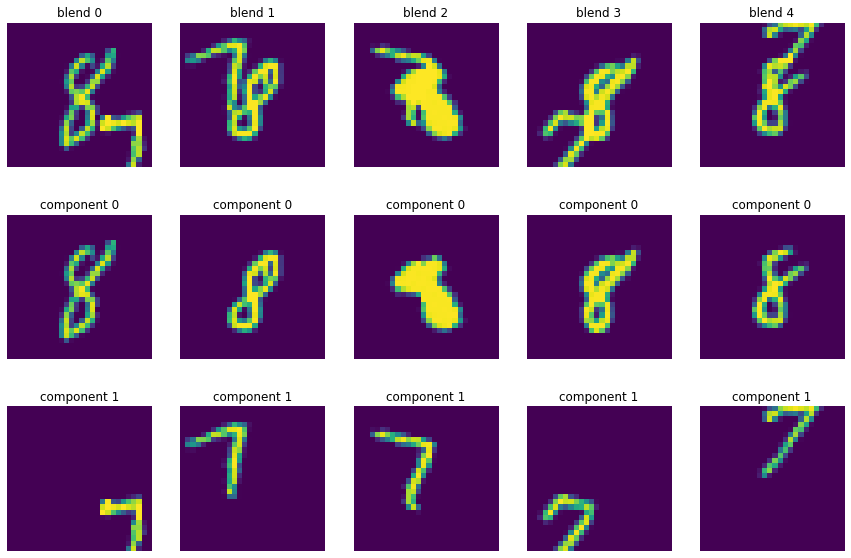

In [6]:
n=5
fig,ax=plt.subplots(3,n,figsize=(3*n, 10))
for i in range(n):
    showimg(blended[i],ax[0,i],f'blend {i}')
    for j in range(comps):
        showimg(components[j,i],ax[j+1,i],f'component {j}')  

In [7]:
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    #x=MaxPooling2D(pool_size=(2,2))(x)
    return x

In [8]:
def decoder(x):
    #x=UpSampling2D(size=(2,2))(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [9]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [10]:
#encoder
inputs=Input(shape=(height,width,1))

encoded=encoder(inputs)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

#decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

In [11]:
encode=Model(inputs,z)
encode.summary()

decode=Model([input_embed],[output1])
decode.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [12]:
encoding=encode(inputs) #define the network
re=decode([encoding])

vae=Model([inputs],[re]) #adds methods of the network
vae.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
functional_1 (Functional)    (None, 32)                219584    
_________________________________________________________________
functional_3 (Functional)    (None, 28, 28, 1)         159169    
Total params: 378,753
Trainable params: 378,753
Non-trainable params: 0
_________________________________________________________________


In [13]:
mse_loss=tf.reduce_mean(mse(inputs,re))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

beta=0.1
kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

vae.compile(optimizer=Adam(learning_rate=0.001))

In [14]:
history=vae.fit(components[0],verbose=1,epochs=20,batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 30s 50ms/step - loss: 8.6891 - mse_loss: 8.4028 - kl_loss: 0.2863
Epoch 2/20
600/600 [==============================] - 31s 52ms/step - loss: 2.5497 - mse_loss: 2.2315 - kl_loss: 0.3182
Epoch 3/20
600/600 [==============================] - 28s 47ms/step - loss: 2.0782 - mse_loss: 1.7618 - kl_loss: 0.3164
Epoch 4/20
600/600 [==============================] - 28s 47ms/step - loss: 1.8724 - mse_loss: 1.5569 - kl_loss: 0.3155
Epoch 5/20
600/600 [==============================] - 28s 47ms/step - loss: 1.7425 - mse_loss: 1.4273 - kl_loss: 0.3151
Epoch 6/20
600/600 [==============================] - 28s 47ms/step - loss: 1.6534 - mse_loss: 1.3386 - kl_loss: 0.3148
Epoch 7/20
600/600 [==============================] - 28s 47ms/step - loss: 1.5871 - mse_loss: 1.2724 - kl_loss: 0.3146
Epoch 8/20
600/600 [==============================] - 30s 51ms/step - loss: 1.5318 - mse_loss: 1.2171 - kl_loss: 0.3146
Epoch 9/20
600/600 [====================

In [15]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z])
    fig, ax = plt.subplots(2, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(output_img[i], ax[1, i], f'output\n{encoding}')
    return idx

[24 17 19 20 14]


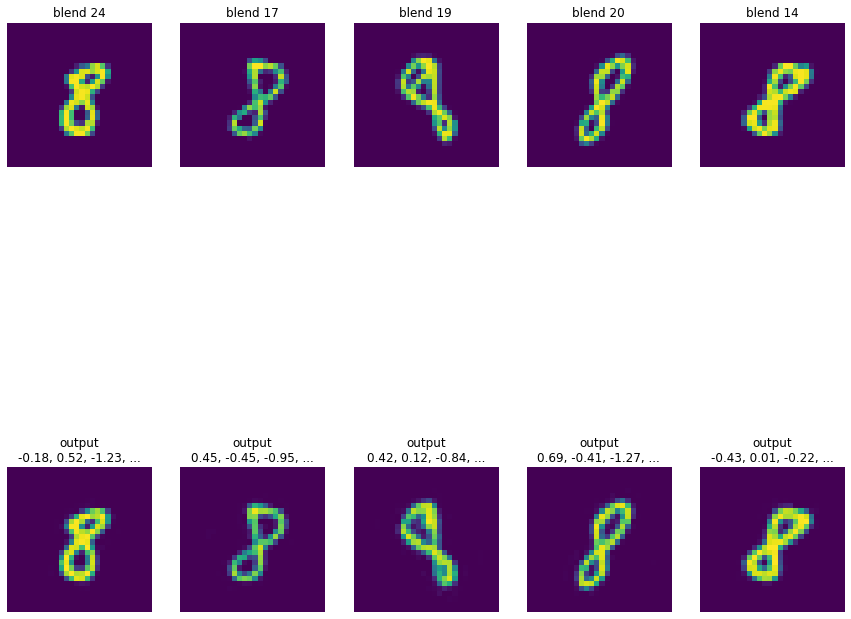

In [16]:
chosen=summary_plot(n,components[0],decode)

In [17]:
#encoder2
inputs2=Input(shape=(height,width,1))

encoded2=encoder(inputs2)
shape=encoded2.get_shape()[1:]
encoded2=Flatten()(encoded2)

z_mean2=Dense(latent_dimensions)(encoded2)
z_log_sigma2=Dense(latent_dimensions)(encoded2)
z2=Lambda(sampling)([z_mean2,z_log_sigma2])

In [18]:
encode2=Model(inputs2,z2)
encode2.summary()

input_compc=Input(shape=(height,width,1))

for layer in decode.layers:
    layer.trainable=False

decode.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_3[0][0]                   
_______________________________________________________________________________________

In [19]:
encoding2=encode2(inputs2) #define the network
re2=decode([encoding2])

vae=Model([inputs2,input_compc],[re2]) #adds methods of the network
vae.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
functional_7 (Functional)       (None, 32)           219584      input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 28, 28, 1)    159169      functional_7[0][0]               
Total params: 378,753
Trainable params: 219,584
Non-trainable params: 159,169
_________

In [20]:
mse_loss=tf.reduce_mean(mse(input_compc,re2))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

beta=0.1
kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma2-tf.square(z_mean2)-tf.exp(z_log_sigma2)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

together=[blended,components[0]]

vae.compile(optimizer=Adam(learning_rate=0.001))

In [21]:
history=vae.fit(together,verbose=1,epochs=20,batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 22s 36ms/step - loss: 9.2440 - mse_loss: 8.9406 - kl_loss: 0.3034
Epoch 2/20
600/600 [==============================] - 21s 36ms/step - loss: 5.6970 - mse_loss: 5.3893 - kl_loss: 0.3076
Epoch 3/20
600/600 [==============================] - 21s 36ms/step - loss: 5.1079 - mse_loss: 4.7998 - kl_loss: 0.3081
Epoch 4/20
600/600 [==============================] - 22s 36ms/step - loss: 4.7741 - mse_loss: 4.4660 - kl_loss: 0.3081
Epoch 5/20
600/600 [==============================] - 22s 36ms/step - loss: 4.5427 - mse_loss: 4.2351 - kl_loss: 0.3076
Epoch 6/20
600/600 [==============================] - 23s 38ms/step - loss: 4.3732 - mse_loss: 4.0653 - kl_loss: 0.3079
Epoch 7/20
600/600 [==============================] - 23s 38ms/step - loss: 4.2322 - mse_loss: 3.9247 - kl_loss: 0.3075
Epoch 8/20
600/600 [==============================] - 23s 39ms/step - loss: 4.1202 - mse_loss: 3.8121 - kl_loss: 0.3080
Epoch 9/20
600/600 [====================

In [22]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    compc=inputs[1][idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z,compc])
    fig, ax = plt.subplots(3, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(compc[i], ax[1, i], f'comp1 {idx[i]}')
        showimg(output_img[i], ax[2, i], f'output\n{encoding}')
    return idx

[15281 21435 44536 13518 47529]


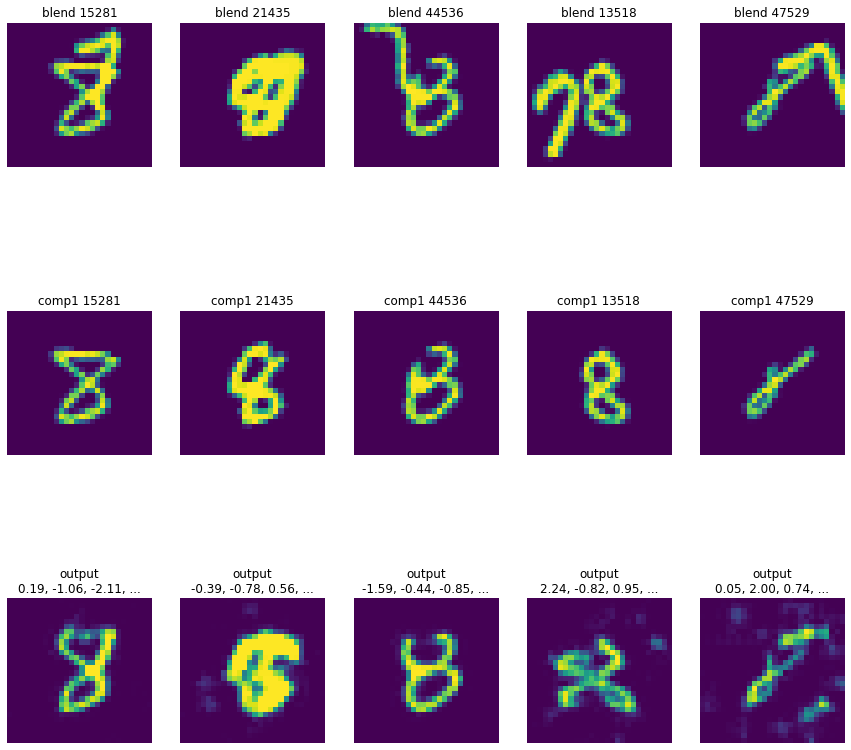

In [23]:
chosen=summary_plot(n,together,decode)